# CAUSAL INFERENCE WITH REAL DATA

This notebooks aims to delineate a process to evaluate causal inference models constructing a semi-synthetic dataset from real data. The process is as follows:

1. Load real data
2. Fit parametric models on treated patients and control patients to predict the outcome. It does not matter if the prediction is good or not, we 
just need to have a model that can construct a semi-synthetic dataset, in which we have all potential outcomes to evaluate the causal inference model.
It is interesting that the parametric models fitted are distinct, as it is done in IHDP setting B, where the potential outcome for control group is
 generated as a linear combination of the features, while the treated outcome is generated as an exponential combination of the features, which 
 implies that the treatment effect is heterogeneous.
3. Construct a semi-synthetic dataset with the fitted models. The semi-synthetic dataset will have the same distribution of the real data, but the 
outcomes are generated by the parametric models fitted in the previous step.
4. Fit the causal inference model on the semi-synthetic dataset and evaluate the performance of the causal inference model.
5. Repeat steps 2 to 4 for different parametric models and compare the performance of the causal inference models.

In [1]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# mlp, random forest
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
# causal inference

from lifelines import CoxPHFitter


In [2]:

from preprocess_data import load_data
from ci_models import *

In [3]:
## Load data
#AML dataset
database, info_dict = load_data()

In [4]:
# Get the features and the outcome

# define the treatment
treatment = info_dict['treatments'][0] # allogeneic hsct
# remove values for autologous hsct
auto = info_dict['treatments'][1]
database = database.loc[database[auto] != 1, :]
# reomve autologous column
database = database.drop(auto, axis=1)



In [5]:
# define the outcome
outcome = 'TIME TO RFS' # time to relapse free survival
event = 'RFS STATUS' # relapse free survival status

# define features
features = info_dict['features']
#remove outcome from features
features.remove(outcome)
# features.remove(treatment)
# features.remove(auto)

In [6]:
#compute corr
corr = database.loc[:, features + [outcome]].corr()
#suprime the features that have a correlation with the outcome greater than 0.9
# features = [feature for feature in features if abs(corr.loc[feature, outcome][0]) < 0.9]
#expand the previous loop
preserved_features =[]
removed_features = []
for feature in features:
    print(feature)
    try:
        pos = abs(corr.loc[feature, outcome][0]) > 0.9
    except:
        pos = abs(corr.loc[feature, outcome]) > 0.9
    if not pos:
        preserved_features.append(feature)
    else:
        removed_features.append(feature)

features = preserved_features

if event not in features:
    features.append(event)

print('Removed features: ', removed_features)
print('Preserved features: ', preserved_features)

STATUS AT HSCT
RESPONSE TO INDUCTION
EFS EVENT
ELN 2017
ELN 2022
WHO 2016
WHO 2022
ICC 2022
FAMILY DONOR
STATUS_OS
STATUS_EFS
RFS STATUS
SEX
SPLENOMEGALY
complex
inv3_t3_3
t_9_22
minus5_5q
mono7
del7q
7other
plus8_8q
del9q
mono12_12p_abn12p
plus13
mono17_17p_abn17p
mono18_18q
mono20_20q
plus21
plus22
monoY
t_15_17
t_8_21
inv16_t16_16
t_6_9
abn3q_other
plus11_11q
mono4_4q_abn(4q)
var_recurr_balanced
var_recurr_unbalanced
MLL_REARRANGED
anomaly chr 1
anomaly chr 2
anomaly chr 3
anomaly chr 4
anomaly chr 5
anomaly chr 6
anomaly chr 7
anomaly chr 8
anomaly chr 9
anomaly chr 10
anomaly chr 11
anomaly chr 12
anomaly chr 13
anomaly chr 14
anomaly chr 15
anomaly chr 16
anomaly chr 17
anomaly chr 18
anomaly chr 19
anomaly chr 20
anomaly chr 21
anomaly chr 22
anomaly chr x
anomaly chr y
ASXL1
ATRX
BCOR
BRAF
CBL
CBLB
CDKN2A
CEBPA_bi
CREBBP
CUX1
DNMT3A
EP300
ETV6
EZH2
FBXW7
FLT3_ITD
FLT3_TKD
GATA2
GNAS
IDH1
IDH2
IKZF1
JAK2
KDM5A
KDM6A
KIT
KRAS
MLL
MLL2
MLL3
MLL5
MPL
Age2
NF1
NPM1
NRAS
PHF6
PRPF40B

In [10]:
#impute nans as 0
database = database.fillna(0)
#impute infinite as 0
database = database.replace([np.inf, -np.inf], 0)
# scale continuous features, save the scaler
cont_features = info_dict['continuous_vars']
scaler = StandardScaler()
database.loc[:, cont_features] = scaler.fit_transform(database.loc[:, cont_features])

# since we want to fit an exponential model, we need to make sure that the outcome is positive, so we add a constant to the outcome
added_value = np.abs(np.min(database.loc[:, outcome])) + 0.001
database['y_positive'] = database.loc[:, outcome]+ added_value

In [11]:
# define the parametric models
models = {'Linear Regression': LinearRegression(),
          'Exponential Regression': LinearRegression(),
          'Cox Regression': CoxPHFitter()
}

In [12]:
# fit the parametric models
# first, fit the linear regression for the control group
# get the control group
control_group = database.loc[database[treatment] == 0, :]
# fit the linear regression
models['Linear Regression'].fit(control_group.loc[:, features].values, control_group.loc[:, 'y_positive'].values)

LinearRegression()

In [13]:
# fit the exponential regression for the treated group
# get the treated group
treated_group = database.loc[database[treatment] == 1, :]
# fit the exponential regression
models['Exponential Regression'].fit(treated_group.loc[:, features], np.log(treated_group.loc[:, 'y_positive']))

LinearRegression()

D:\Programas\anaconda3\envs\docencia\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
D:\Programas\anaconda3\envs\docencia\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\aleja\AppData\Local\Temp\ipykernel_25004\3062392974.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_true - y_pred, ax=axs[0])
C:\Users\aleja\AppData\Local\Temp\ipykernel_25004\3062392974.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in se

Control group
R2:  0.9843577045443365
MSE:  0.6508649753084195
MAE:  0.7981046197761751
Treated group
R2:  -4.579273194707785
MSE:  2.9240420696214984
MAE:  0.9344941782591858


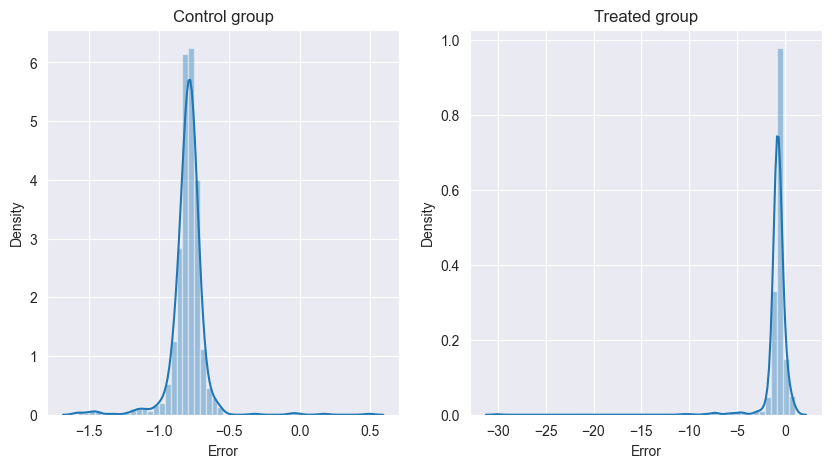

D:\Programas\anaconda3\envs\docencia\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


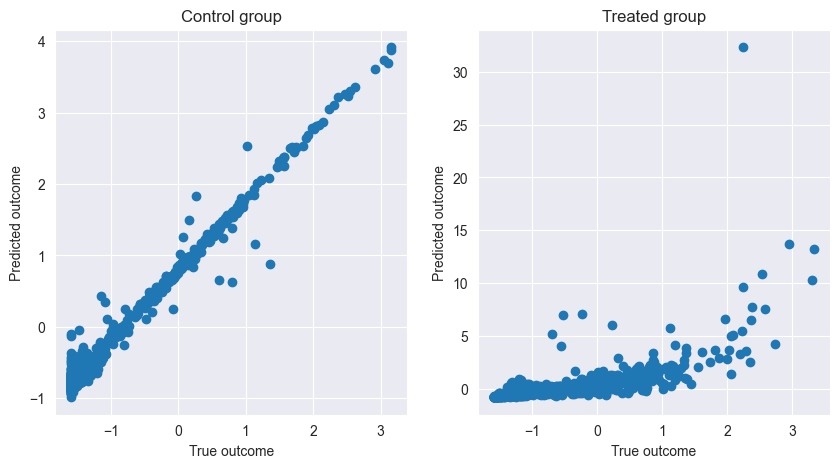

In [14]:
# check the performance of the models
# check the performance of the models
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# control group
y_pred = models['Linear Regression'].predict(control_group[features]) - added_value
y_true = control_group[outcome] - added_value
print('Control group')
print('R2: ', models['Linear Regression'].score(control_group[features], control_group['y_positive']))
print('MSE: ', mean_squared_error(y_true, y_pred))
print('MAE: ', mean_absolute_error(y_true, y_pred))
# plot the distribution of errors
sns.distplot(y_true - y_pred, ax=axs[0])
axs[0].set_title('Control group')
axs[0].set_xlabel('Error')
axs[0].set_ylabel('Density')
# treated group
y_pred = np.exp(models['Exponential Regression'].predict(treated_group[features])) - added_value
y_true = treated_group[outcome] - added_value
print('Treated group')
print('R2: ', models['Exponential Regression'].score(treated_group[features], treated_group['y_positive']))
print('MSE: ', mean_squared_error(y_true, y_pred))
print('MAE: ', mean_absolute_error(y_true, y_pred))
# plot the distribution of errors
sns.distplot(y_true - y_pred, ax=axs[1])
axs[1].set_title('Treated group')
axs[1].set_xlabel('Error')
axs[1].set_ylabel('Density')
plt.show()

# plot the predictions vs outcomes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# control group
y_pred = models['Linear Regression'].predict(control_group[features]) - added_value
y_true = control_group[outcome] - added_value
axs[0].scatter(y_true, y_pred)
axs[0].set_title('Control group')
axs[0].set_xlabel('True outcome')
axs[0].set_ylabel('Predicted outcome')
# treated group
y_pred = np.exp(models['Exponential Regression'].predict(treated_group[features])) - added_value
y_true = treated_group[outcome] - added_value
axs[1].scatter(y_true, y_pred)
axs[1].set_title('Treated group')
axs[1].set_xlabel('True outcome')
axs[1].set_ylabel('Predicted outcome')
plt.show()

In [15]:
# generate the potential outcomes with the fitted models
# first, generate y0 for all patients
database['y0'] = models['Linear Regression'].predict(database.loc[:, features]) - added_value
# second, generate y1 for all patients
database['y1'] = np.exp(models['Exponential Regression'].predict(database.loc[:, features])) - added_value

D:\Programas\anaconda3\envs\docencia\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [16]:
# add noise to potential outcomes, save mu0 and mu1 as the noiselees versions, y0 and y1 as the noisy versions
# first, add noise to y0
database['mu0'] = database['y0']
database['y0'] = database['y0'] + np.random.normal(0, 1, size=database.shape[0])
# second, add noise to y1
database['mu1'] = database['y1']
database['y1'] = database['y1'] + np.random.normal(0, 1, size=database.shape[0])

In [17]:
# add the treatment variable
database['t'] = database[treatment]

# add the factual outcome, which is y0 where the treatment is 0 and y1 where the treatment is 1
database['y'] = database['y0']
database.loc[database['t'] == 1, 'y'] = database.loc[database['t'] == 1, 'y1']

C:\Users\aleja\AppData\Local\Temp\ipykernel_25004\2345055460.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(database['y'], label='Synthetic outcome')
C:\Users\aleja\AppData\Local\Temp\ipykernel_25004\2345055460.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(database[outcome], label='Fa

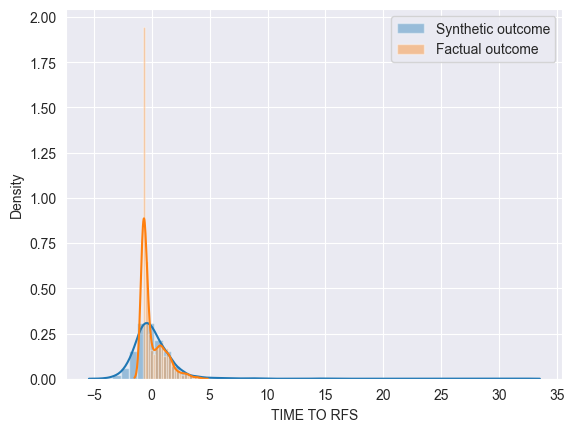

In [18]:
# plot the distribution of the synthetic outcome in comparison with the factual outcome
sns.distplot(database['y'], label='Synthetic outcome')
sns.distplot(database[outcome], label='Factual outcome')
plt.legend()
plt.show()

plt.show()
## CAUSAL INFERENCE METHODS

Three well known methods for causal inference are the S-learner, the T-learner and the TARNET are implementes.

As you may know, S-Learner and T-learner are model agnostic methods, so we will use a linear regression and a random forest and a Neural Network as
 base learners. The Parameters of neural networks implementations (defined in config dict) are not in the scope of this notebook.

In [19]:
# evaluate causal inference methods with the semi-synthetic dataset
# define the causal inference methods

config= {'slearner': {'NE':3000, 'hidden_layers': (50, 25)},
         'tlearner': {'NE':3000, 'hidden_layers': (50, 25)},
         'tarnet': {'NE': 1000, 'batch_size': 1000, 'patience':40,
                    'NL_phi': 3, 'NL_y': 2, 'NN_phi': 200, 'NN_y': 100
                    }}

ci_models = {'slearner':{"Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "Neural Network": MLPRegressor(hidden_layer_sizes=config['slearner']['hidden_layers'], max_iter=config['slearner']['NE'],
                                           random_state=42)},
          'tlearner':{"Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "Neural Network": MLPRegressor(hidden_layer_sizes=config['tlearner']['hidden_layers'], max_iter=config['tlearner']['NE'],
                                           random_state=42)},
          'tarnet': {'TARNET': None},
}

In [20]:
# make several train-test splits of the dataset
Num_exps = 10
# make splits
pehe_dict = {ci_model:{} for ci_model in ci_models.keys()}
ate_dict = {ci_model:{} for ci_model in ci_models.keys()}
for i_exp in range(1, Num_exps+1):
    print(f'Experiment {i_exp}')
    # make train-test split
    train = database.sample(frac=0.7, random_state=i_exp)
    test = database.loc[~database.index.isin(train.index), :]
    # get the features and the outcome
    x_train, t_train, y_train = train.loc[:, features], train.loc[:, 't'], train.loc[:, 'y']
    x_test, t_test, y_test = test.loc[:, features], test.loc[:, 't'], test.loc[:, 'y']
    data = {'data_train': (x_train, t_train, y_train), 'data_test': (x_test, t_test, y_test)}
    true_y = {'y_train': y_train, 'y_test': y_test, 'mu0_train': train.loc[:, 'mu0'], 'mu1_train': train.loc[:, 'mu1'],
                'mu0_test': test.loc[:, 'mu0'], 'mu1_test': test.loc[:, 'mu1']}
    # fit the causal inference models
    for ci_model in ci_models.keys():
        predicted_y = predict_causal_effects(ci_models[ci_model], data,
                                             learner=ci_model, config=config)
        pehe, ate_error = evaluate_causal_inference(ci_models[ci_model], true_y, predicted_y)
        pehe_dict[ci_model][f'exp_{i_exp}'] = pehe
        ate_dict[ci_model][f'exp_{i_exp}'] = ate_error

Experiment 1
Model: Linear Regression, MSE on train data: 1.94
Model: Linear Regression, MSE on test data: 1.70
Model: Linear Regression, PEHE (Train): 45411783350.08
Model: Linear Regression, PEHE (Test): 39464209221.80
Model: Random Forest, MSE on train data: 0.33
Model: Random Forest, MSE on test data: 1.24
Model: Random Forest, PEHE (Train): 45411783350.07
Model: Random Forest, PEHE (Test): 39464209221.82
Model: Neural Network, MSE on train data: 0.09
Model: Neural Network, MSE on test data: 2.79
Model: Neural Network, PEHE (Train): 45411783350.07
Model: Neural Network, PEHE (Test): 39464209221.81
Model: Linear Regression, MSE on train data: 1.47
Model: Linear Regression, MSE on test data: 2.24
Model: Linear Regression, PEHE (Train): 45411783349.86
Model: Linear Regression, PEHE (Test): 39464209221.48
Model: Random Forest, MSE on train data: 0.31
Model: Random Forest, MSE on test data: 1.30
Model: Random Forest, PEHE (Train): 45411783349.94
Model: Random Forest, PEHE (Test): 394642

# EVALUATION PEHE

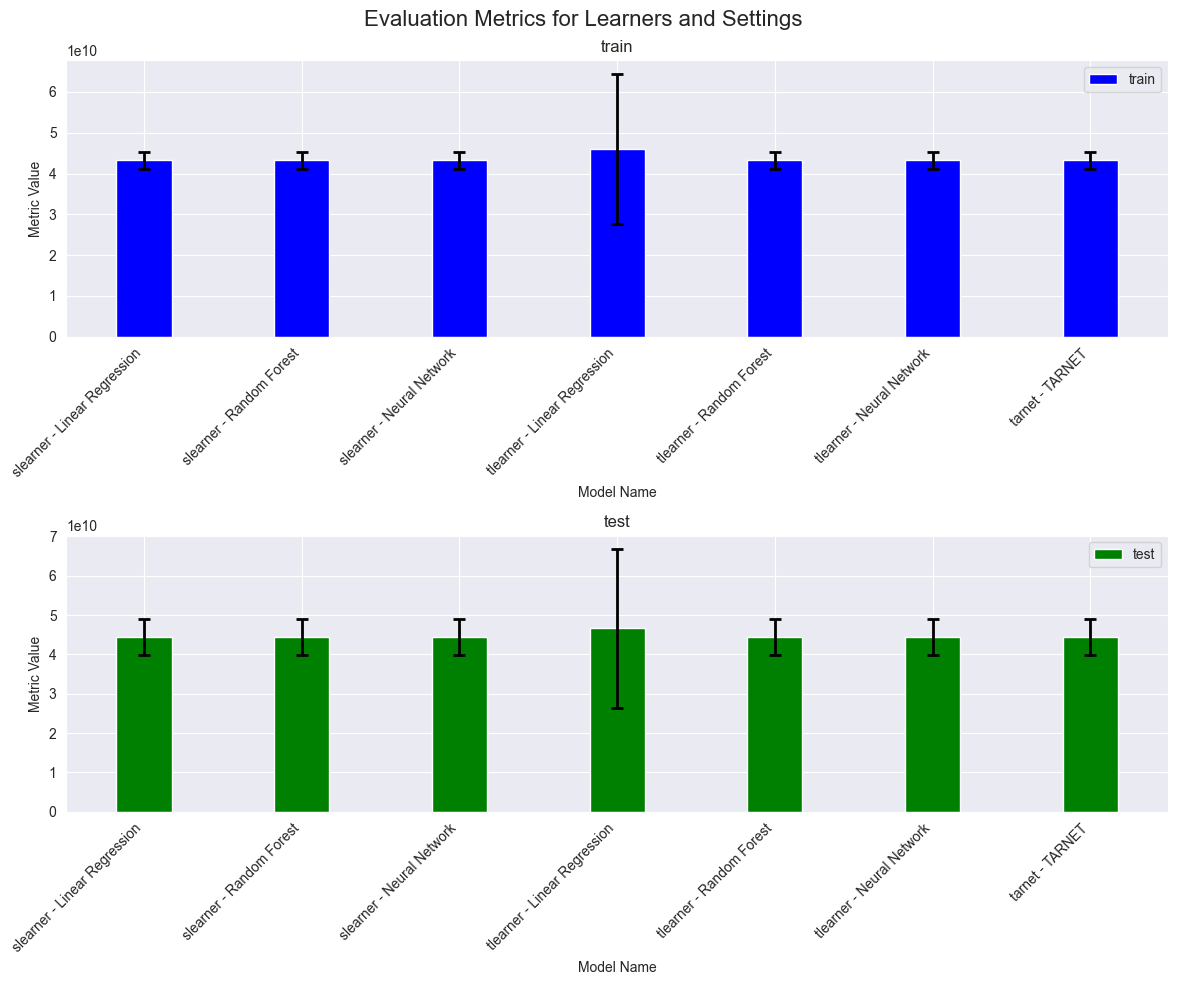

In [21]:
plot_mean_pehes(Num_exps, ci_models.keys(),  pehe_dict)

# EVALUATION ATE

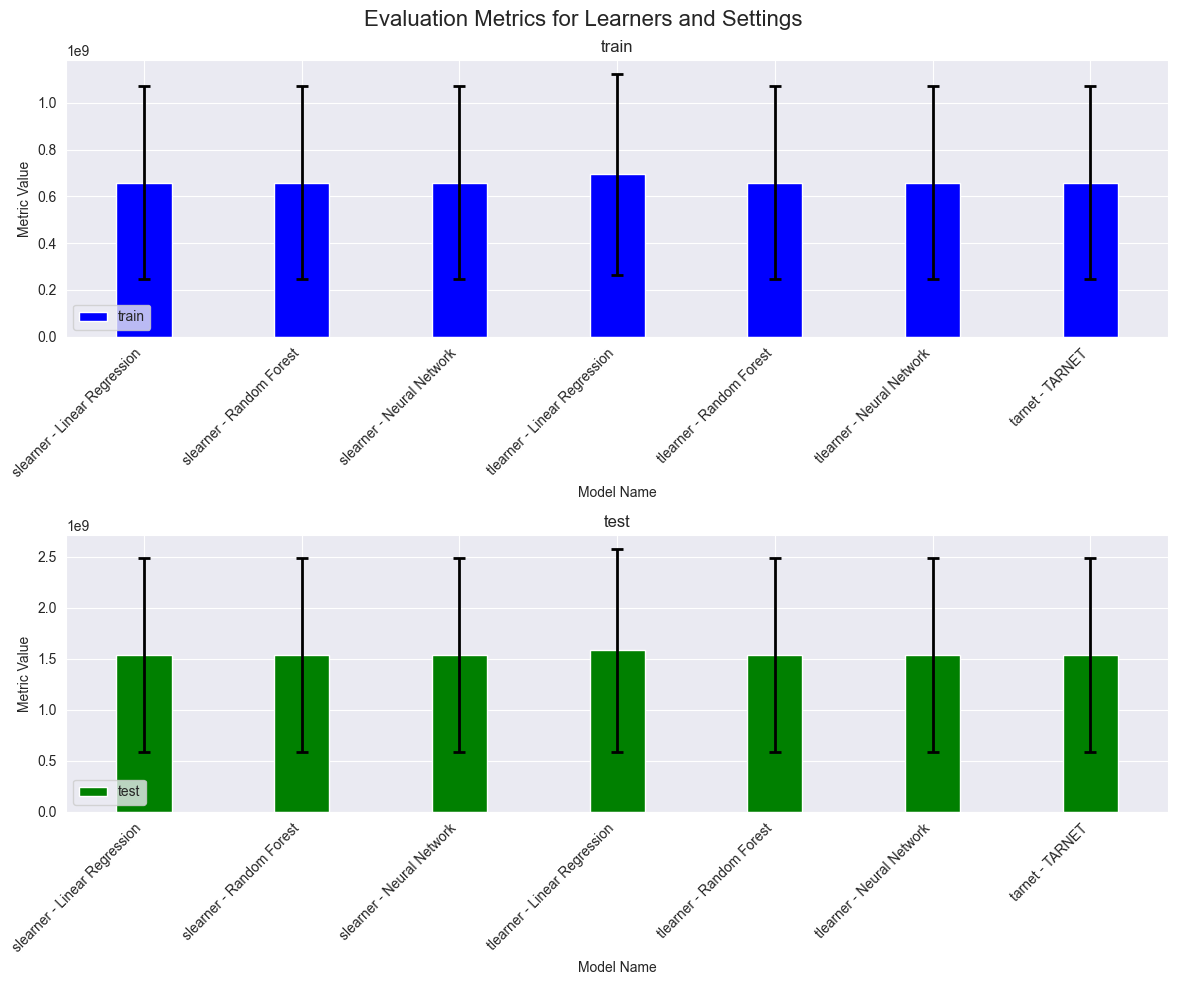

In [22]:
plot_mean_pehes(Num_exps, ci_models.keys(),  ate_dict)